# MIR DWT for Kex

> A parsimonious approach to soil spectroscopy

In [ ]:
%load_ext autoreload
%autoreload 2

## Imports

In [ ]:
from pathlib import Path
from functools import partial
from tqdm import tqdm

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import numpy as np

import pywt
# import timm
# from torcheval.metrics import R2Score
# from torch.optim import lr_scheduler
# from torch import optim, nn

from lssm.loading import load_ossl
from lssm.preprocessing import ToAbsorbance, ContinuumRemoval, Log1p, MeanCenter
# from lssm.dataloaders import SpectralDataset, get_dls
# from lssm.callbacks import (MetricsCB, BatchSchedCB, BatchTransformCB,
#                             DeviceCB, TrainCB, ProgressCB)
# from lssm.transforms import GADFTfm, _resizeTfm, StatsTfm
# from lssm.learner import Learner


## Data loading & preprocessing

In [ ]:
analytes = 'k.ext_usda.a725_cmolc.kg'
spectra_type = 'mir'

data = load_ossl(analytes, spectra_type)
X, y, X_names, smp_idx, ds_name, ds_label = data

X = Pipeline([('to_abs', ToAbsorbance()),
              ('center', MeanCenter())]).fit_transform(X)
            #   ('cr', ContinuumRemoval(X_names))]).fit_transform(X)
             
y = Log1p().fit_transform(y)

Reading & selecting data ...


In [ ]:
X_names

array([ 600,  602,  604, ..., 3996, 3998, 4000])

In [ ]:
# Train/valid split
n_smp = None  # For demo. purpose
X_train, X_valid, y_train, y_valid = train_test_split(X[:n_smp, :], y[:n_smp],
                                                      test_size=0.1,
                                                      stratify=ds_name[:n_smp],
                                                      random_state=41)

In [ ]:
X.shape[-1]

1701

In [ ]:
wavelet_name='db1'
max_level = pywt.dwt_max_level(data_len=X.shape[-1], 
                               filter_len=pywt.Wavelet(wavelet_name).dec_len)

In [ ]:
max_level

10

In [ ]:
X[0].shape

(1701,)

In [ ]:
level6 = []
for x in tqdm(X): 
    x_t = pywt.wavedec(x, wavelet_name, level=max_level)
    level6.append(x_t[6])

100%|██████████| 57674/57674 [00:01<00:00, 30183.74it/s]


In [ ]:
X_6 = np.stack(level6)

In [ ]:
np.argmax(np.std(X_6, axis=0))

48

In [ ]:
X_6[:5, :5]

array([[ 0.03672203, -0.02487039, -0.01717581, -0.10592943, -0.00370914],
       [ 0.02036096, -0.01819576, -0.00826929, -0.11572447,  0.00565771],
       [ 0.01855459, -0.0183915 ,  0.01321602, -0.14775897,  0.00482524],
       [ 0.03207238, -0.02084354, -0.02947322, -0.11373378, -0.01840138],
       [-0.07371182, -0.0093682 ,  0.10967408, -0.23055396,  0.07454462]])

In [ ]:
np.concatenate(level0, axis=0)

array([-2.01083716,  5.5876866 , -2.01955983, ...,  2.51502106,
       -0.91717877,  2.55590697])

In [ ]:
for i, level in enumerate(X_t):
    print(i, ': ', level.shape)

0 :  (2,)
1 :  (2,)
2 :  (4,)
3 :  (7,)
4 :  (14,)
5 :  (27,)
6 :  (54,)
7 :  (107,)
8 :  (213,)
9 :  (426,)
10 :  (851,)


In [ ]:
X_t = pywt.wavedec(X[0], wavelet_name, level=max_level)

In [ ]:
X_t

array([-2.16663109e-01, -1.23866352e-01,  5.68868220e-01, -1.21852654e-01,
       -6.71356980e-01, -5.70421031e-01, -2.10824324e-01,  7.34801709e-02,
        3.52682421e-01,  2.03533434e-01,  1.63918509e-01, -2.15796507e-01,
       -5.30099870e-01,  9.25218828e-17])

In [ ]:
class DWT(BaseEstimator, TransformerMixin):
    def __init__(self, 
                 names, 
                 wavenumbers,
                 top_percentile=1,
                 levels=range(4, 9), 
                 wavelet_name='db1'):
        ls
        
        self.data = {'level': [], 'smp_name': [],
                     'wavenumber': [], 'coeff': [],
                     'resolution': [] # in wavenumbers
                     }
        
    def _compute_coeffs(self, x):
        max_level = pywt.dwt_max_level(data_len=len(x), 
                                       filter_len=pywt.Wavelet(self.wavelet_name).dec_len)
        return pywt.wavedec(x, self.wavelet_name, level=max_level)

    def _idx_of_percentile(self, arr, percentile):
        threshold = np.percentile(arr, percentile)  
        top_indices = np.where(arr >= threshold)[0]
        return top_indices[np.argsort(arr[top_indices])[::-1]]
    
    def _get_upsampling_factor(self, signal_length, n_coeffs):
        return round((signal_length/n_coeffs) / 2) * 2
    
    def _get_wn(self, idx, signal_length, n_coeffs): 
        # print(signal_length/n_coeffs)
        upsampling_factor = self._get_upsampling_factor(signal_length, n_coeffs)
        # print(upsampling_factor)
        # print(self.wavenumbers[round(idx * (signal_length/n_coeffs))])
        # print(round(self.wavenumbers[idx * upsampling_factor + int(upsampling_factor/2)]))
        # print(20*'-')
        # return round(self.wavenumbers[idx * upsampling_factor + int(upsampling_factor/2)])
        return self.wavenumbers[round(idx * (signal_length/n_coeffs))]
    def fit(self, X, y=None): return self
    
    def transform(self, X):
        # For each sample
        for idx_smp, name in enumerate(self.names):
            coeffs = self._compute_coeffs(X[idx_smp])
            # For each DWT decomposition level
            for idx_level in self.levels:
                # print('level: ', idx_level)
                n_coeffs = len(coeffs[idx_level])
                # For each coeff
                for idx in self._idx_of_percentile(coeffs[idx_level], 100 - self.top_percentile):
                    # print(len(X[idx_smp]))
                    # print('upsampling x: ', round((signal_length/n_coeffs) / 2) * 2)
                    # print('n_coeffs: ', n_coeffs, '\n')
                    self.data['smp_name'].append(name)
                    self.data['level'].append(idx_level)
                    self.data['wavenumber'].append(self._get_wn(idx, len(X[idx_smp]), n_coeffs))
                    self.data['coeff'].append(coeffs[idx_level][idx])
                    self.data['resolution'].append(2*self._get_upsampling_factor(signal_length, n_coeffs))
        return pd.DataFrame(self.data)

In [ ]:

# Get PyTorch datasets
train_ds, valid_ds = [SpectralDataset(X, y, )
                      for X, y, in [(X_train, y_train), (X_valid, y_valid)]]

In [ ]:
# Then PyTorch dataloaders
dls = get_dls(train_ds, valid_ds, bs=1)

## DL model ensembling

In [ ]:
model_name = 'resnet18'
model = timm.create_model(model_name, pretrained=True,
                          in_chans=1, num_classes=1)

In [ ]:
def apply_mod(m, f):
    f(m)
    for l in m.children(): apply_mod(l, f)

def set_grad(m, b):
    if isinstance(m, (nn.Linear,nn.BatchNorm2d)): return
    if hasattr(m, 'weight'):
        for p in m.parameters(): p.requires_grad_(b) 

In [ ]:
apply_mod(model, partial(set_grad, b=False))

In [ ]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

10113

In [ ]:
# Define modelling pipeline & Train
epochs = 3
lr = 5e-3

metrics = MetricsCB(r2=R2Score())

tmax = epochs * len(dls.train)

# xtra = [BatchSchedCB(sched)]

gadf = BatchTransformCB(GADFTfm())
resize = BatchTransformCB(_resizeTfm)
stats = BatchTransformCB(StatsTfm(model.default_cfg))

cbs = [DeviceCB(), gadf, resize, stats, TrainCB(),
       metrics, ProgressCB(plot=False)]

learn = Learner(model, dls, nn.MSELoss(), lr=lr,
                cbs=cbs, opt_func=optim.AdamW)

ok
ok


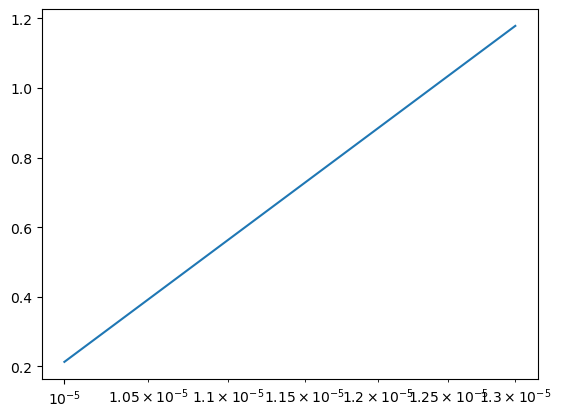

In [ ]:
learn.lr_find()

In [ ]:
model_name = 'resnet18'
model = timm.create_model(model_name, pretrained=True,
                          in_chans=1, num_classes=1)

# Define modelling pipeline & Train
epochs = 3
lr = 2e-4

metrics = MetricsCB(r2=R2Score())

tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)

xtra = [BatchSchedCB(sched)]

gadf = BatchTransformCB(GADFTfm())
resize = BatchTransformCB(_resizeTfm)
stats = BatchTransformCB(StatsTfm(model.default_cfg))

cbs = [DeviceCB(), gadf, resize, stats, TrainCB(),
       metrics, ProgressCB(plot=False)]

learn = Learner(model, dls, nn.MSELoss(), lr=lr,
                cbs=cbs+xtra, opt_func=optim.AdamW)


In [ ]:
learn.fit(epochs)

KeyboardInterrupt: 